In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pymorphy2
import urllib.request
import json   
import requests

from pymorphy2.tokenizers import simple_word_tokenize
from pymorphy2.shapes import is_punctuation
from collections import Counter
from stop_words import get_stop_words
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.externals import joblib

In [22]:
df = pd.read_csv("../data/itil-tickets-6.csv", sep=',')
# df = pd.read_clipboard()
# df.to_csv('../data/itil-tickets-6.csv', index=False)
df = df.dropna()
display(df.sample(n=5).head())
display(df.shape)

,route,specialist,title,category,analytics1,analytics2,analytics3,user
10637,зо,Манюхин Андрей,Доработка ТЗ по замечаниям пользователей,Разработка процесса,Отдел разработки 1С,1С УТ 11,Поддержка УТ11,Манюхин Андрей
8702,зо,Евхута Надежда,товарный отчет,Консультация,Розничный магазин,1С Розница для Беларуси,Розница,Дубовик Вадим
9262,зо,Талаева Вера,Изменение подразделения у специалиста по прода...,Изменение данных,Офистон,1С УТ 11,Поддержка УТ11,Бородич Дмитрий
5633,зо,Малеев Егор,FW: запрос на собственное потребление,Изменение данных,Маркетинг,1С УТ 11,Поддержка УТ11,Корженок Екатерина
8748,зо,Быков Вадим,Навигация в машине,WEB-services::BelTransSAT,Транспортная логистика,Программное обеспечение,Поддержка инфраструктуры,Луценко Татьяна


(13781, 8)

In [28]:
def show_distr(df, name, threshold=100):
    df_ = df.copy()
    grouped = df_[name].value_counts()
    grouped = grouped[grouped>=threshold]
#     display(grouped)

    fig = plt.figure(figsize=(12,12))
    ax = grouped.sort_values(ascending=True).plot.barh(ylim=0)
    plt.savefig('%s.png'%(name))
#     ax.axhline(y='Email')
#     plt.plot((0, 'Email'), (3000, 'Email'), 'k-')
    plt.show()

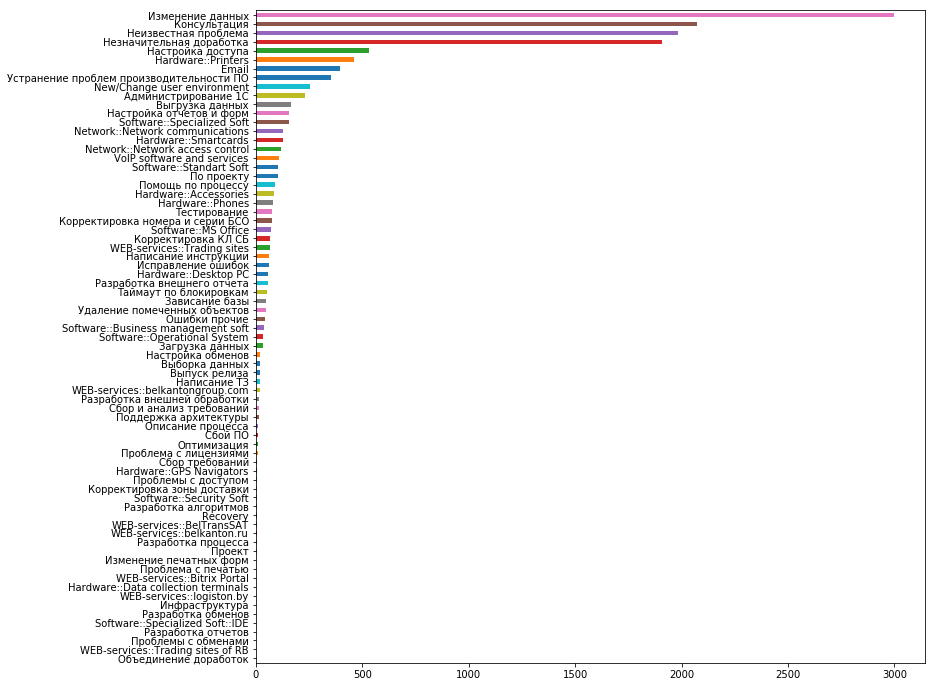

In [29]:
show_distr(df, 'category', 0)

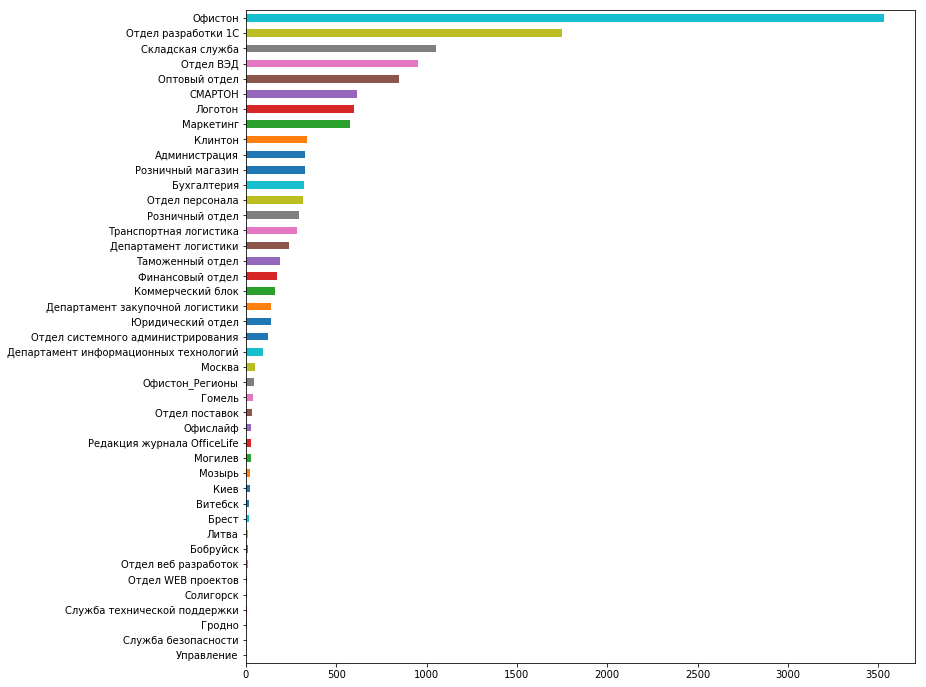

In [30]:
show_distr(df, 'analytics1', 0)

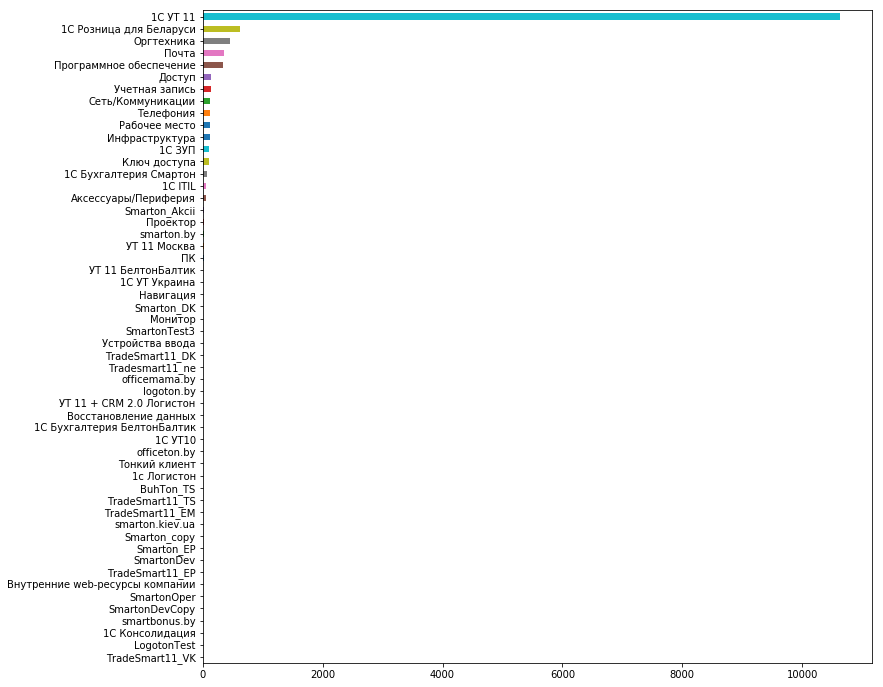

In [31]:
show_distr(df, 'analytics2', 0)

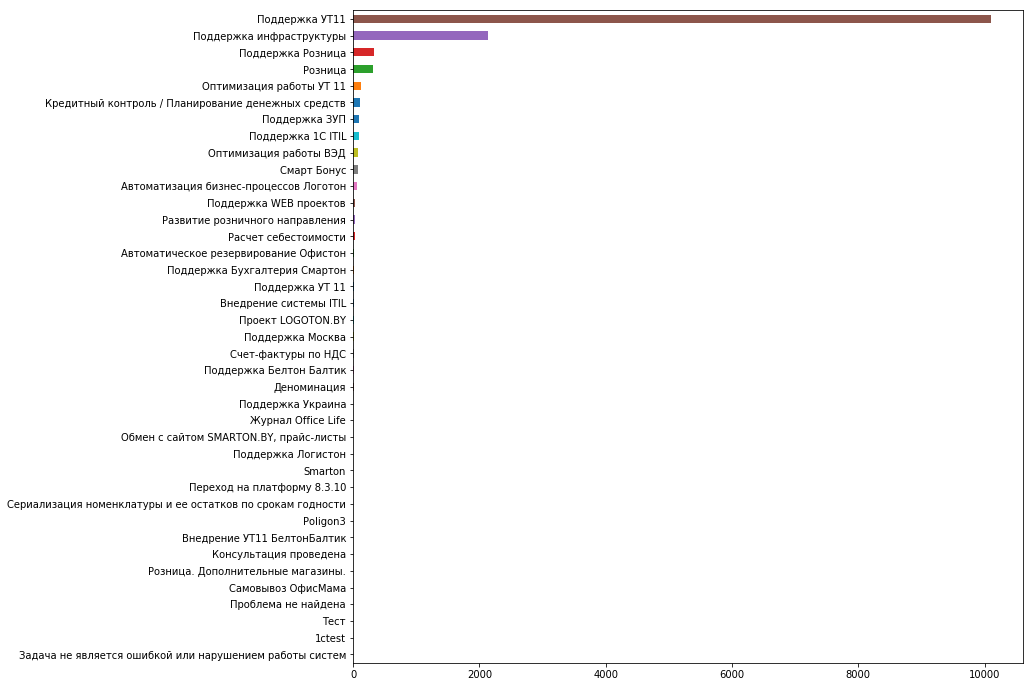

In [32]:
show_distr(df, 'analytics3', 0)

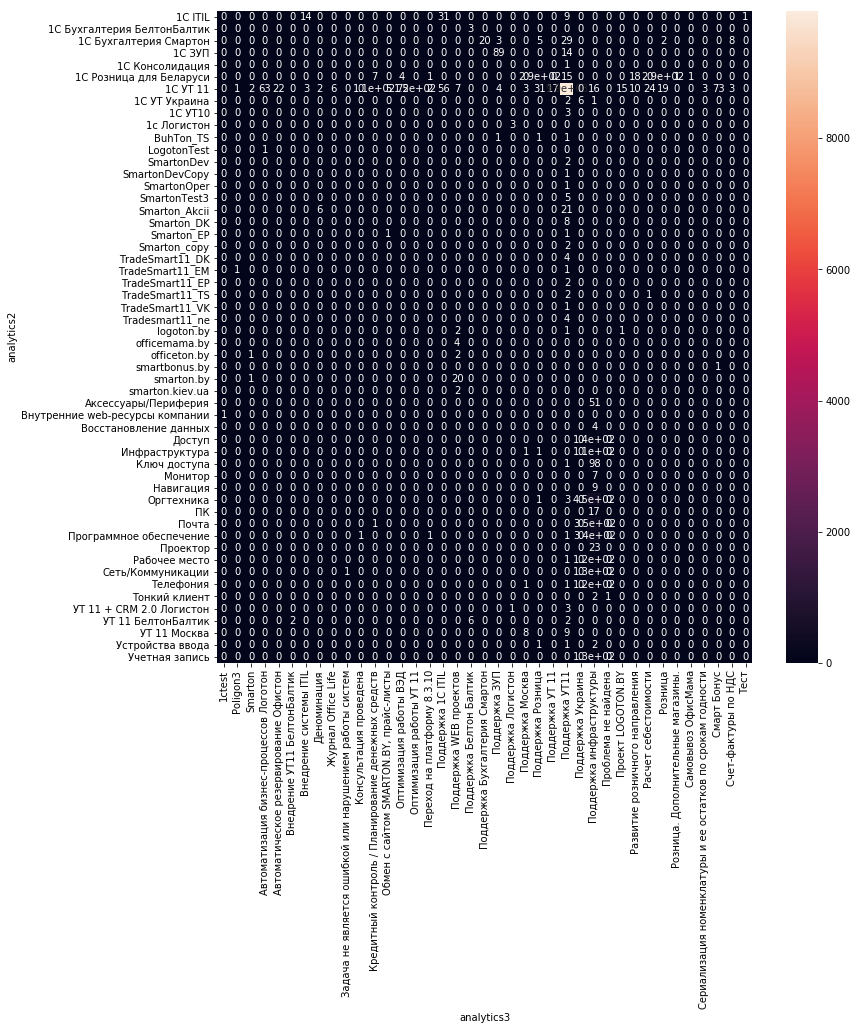

In [21]:
df_analytics = df[['analytics2', 'analytics3']]

df_analytics_unst = df_analytics.groupby('analytics2')['analytics3'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_analytics_unst, annot=True)
plt.show()

Талаева Вера                        4315
Евхута Надежда                      1965
Манюхин Андрей                      1623
Баранов Александр                    974
Швец Богдан                          818
Быков Вадим                          787
Сивицкая Татьяна                     426
Малеев Егор                          414
Покровский Евгений                   414
Руководители службы Service Desk     311
Кухарчук Дмитрий                     286
Кропис Юлия                          243
Шевчик Юрий                          233
Полегошко Андрей                     230
Зезюлькин Сергей                     228
Королев Владимир                     192
Шкурупий Денис                       126
Name: specialist, dtype: int64

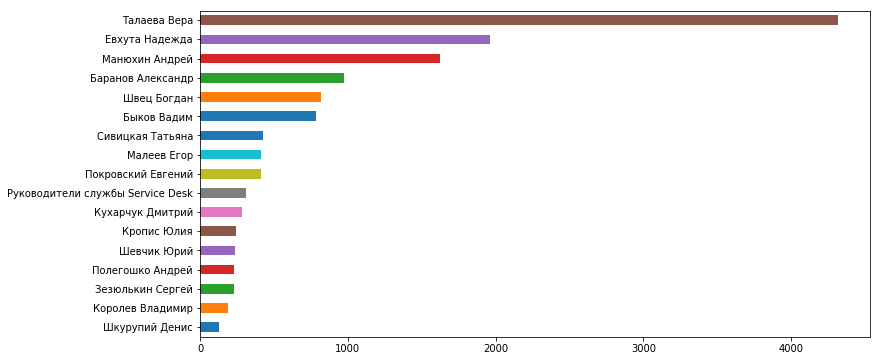

In [141]:
show_distr(df, 'specialist')

In [144]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data.head()

,route,specialist,title,category,analytics1,analytics2,analytics3,user
5018,зо,Евхута Надежда,заказы с сайта,Незначительная доработка,Розничный отдел,1С УТ 11,Поддержка УТ11,Севернева Вероника
8653,зо,Талаева Вера,просьба отменить корректировку реализации,Изменение данных,Розничный отдел,1С УТ 11,Поддержка УТ11,Драгун Елена
14046,зи,Манюхин Андрей,ликвидирован контрагент,Незначительная доработка,Отдел разработки 1С,1С УТ 11,Поддержка УТ11,Манюхин Андрей
4060,зо,Баранов Александр,не работает рабочий стол и удал. доступ,Software::Operational System,Оптовый отдел,Программное обеспечение,Поддержка инфраструктуры,Ладутько Наталья
1322,зо,Баранов Александр,Не работает телефон,VoIP software and services,Департамент информационных технологий,Телефония,Поддержка инфраструктуры,Войтко Сергей


### Elastic Search Baseline

### Preprocessing

In [145]:
df['specialist'].replace(['Руководители службы Service Desk', 'Шкурупий Денис'], 'Манюхин Андрей', inplace=True)
df['specialist'].replace('Кухарчук Дмитрий', 'Сергиевич Юрий', inplace=True)
df['specialist'].replace('Талаева Вера', 'Кропис Юлия', inplace=True)
df['specialist'].replace('Быков Вадим', 'Полегошко Андрей', inplace=True)

grouped = df['specialist'].value_counts()
print(grouped.index[0], grouped.iloc[0]/grouped.sum())

users_minor = grouped[grouped<=10]
print(users_minor)

Кропис Юлия 0.3307452289383934
Диспетчерская служба Service Desk          8
Соломянко Сергей                           7
Поддержка инфраструктуры                   7
Менеджеры процесса управления запросами    1
Менеджеры релизов и их развертывания       1
Name: specialist, dtype: int64


In [146]:
for um in users_minor.index:
    df = df.loc[df['specialist']!=um]

In [147]:
# specialist to category
col = ['specialist', 'title']
df = df[col]
df = df[pd.notnull(df['title'])]

df['category_id'] = df['specialist'].factorize()[0]
category_id_df = df[['specialist', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'specialist']].values)
df.head()

,specialist,title,category_id
1,Манюхин Андрей,проверка работы,0
3,Манюхин Андрей,Test!,0
4,Манюхин Андрей,Проверка работы itil,0
5,Манюхин Андрей,Test md,0
7,Манюхин Андрей,Проверка работы ITIL,0


In [148]:
def replace_by_re(s, pattern, repl):
    return re.sub(pattern, repl, s)

df['title'] = df['title'].apply(replace_by_re, args=('1[CСcс]', "1С"))
df['title'] = df['title'].apply(replace_by_re, args=('FW:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('RE:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('(\d{2}[\.\\\/]){2}(\d{2})+', "дата"))
# df['title'] = df['title'].apply(replace_by_re, args=("[\:\#\№%\!\d\-\'\.]", ""))
# df['title'] = df['title'].apply(replace_by_re, args=('\"', ""))

df = df[df['title']!='']

df['title'].loc[:10]

1          проверка работы
3                    Test!
4     Проверка работы itil
5                  Test md
7     Проверка работы ITIL
9                 проверка
10                    Test
Name: title, dtype: object

In [150]:
morph = pymorphy2.MorphAnalyzer()
cnt = Counter()
stop_words = get_stop_words('russian')

def lemmatize(s):
    l = [morph.parse(w)[0].normal_form for w in simple_word_tokenize(s) if not is_punctuation(w)]
    l = [w for w in l if w not in stop_words]
    
    cnt.update(l)
    
    return " ".join(l)

df['title'] = df['title'].apply(lemmatize)

df['title'].loc[:10]

1          проверка работа
3                     test
4     проверка работа itil
5                  test md
7     проверка работа itil
9                 проверка
10                    test
Name: title, dtype: object

### Transform

In [157]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.title).toarray()
labels = df.category_id
features.shape

(13757, 2428)

In [158]:
fnames = tfidf.get_feature_names()
print(fnames[-10:])

['этап', 'этикетка', 'юр', 'юр адрес', 'юрист', 'язык', 'январь', 'ярлык', 'ячейка', 'ящик']


### Model Search

In [159]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)

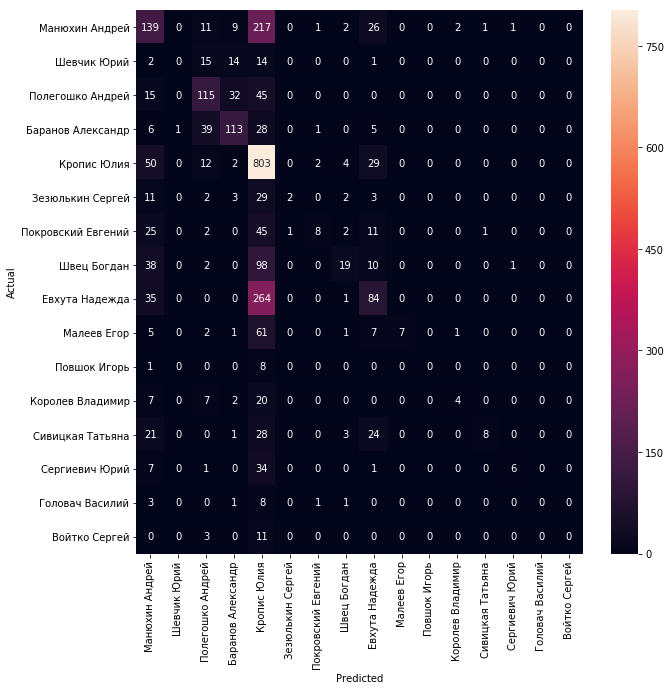

In [160]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.specialist.values, yticklabels=category_id_df.specialist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('heatmap.png')

In [161]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))

                    precision    recall  f1-score   support

    Манюхин Андрей       0.38      0.34      0.36       409
       Шевчик Юрий       0.00      0.00      0.00        46
  Полегошко Андрей       0.55      0.56      0.55       207
 Баранов Александр       0.63      0.59      0.61       193
       Кропис Юлия       0.47      0.89      0.61       902
  Зезюлькин Сергей       0.67      0.04      0.07        52
Покровский Евгений       0.62      0.08      0.15        95
       Швец Богдан       0.54      0.11      0.19       168
    Евхута Надежда       0.42      0.22      0.29       384
       Малеев Егор       1.00      0.08      0.15        85
      Повшок Игорь       0.00      0.00      0.00         9
  Королев Владимир       0.57      0.10      0.17        40
  Сивицкая Татьяна       0.80      0.09      0.17        85
    Сергиевич Юрий       0.75      0.12      0.21        49
   Головач Василий       0.00      0.00      0.00        14
     Войтко Сергей       0.00      0.00

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [162]:
model.fit(features, labels)
N = 2
for user, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(user))
  print("  . Top unigrams: {}".format(', '.join(unigrams)))
  print("  . Top bigrams: {}".format(', '.join(bigrams)))

# 'Баранов Александр':
  . Top unigrams: переадресация, доступ
  . Top bigrams: работать телефон, переадресация почта
# 'Войтко Сергей':
  . Top unigrams: сотрудник, новый
  . Top bigrams: новый сотрудник, доступ 1с
# 'Головач Василий':
  . Top unigrams: сайт, белкантон
  . Top bigrams: сайт белкантон, сайт бкг
# 'Евхута Надежда':
  . Top unigrams: подарок, база
  . Top bigrams: орг вопрос, розница орг
# 'Зезюлькин Сергей':
  . Top unigrams: 1с, база
  . Top bigrams: копия база, missing value
# 'Королев Владимир':
  . Top unigrams: доступ, новый
  . Top bigrams: учётный запись, новый сотрудник
# 'Кропис Юлия':
  . Top unigrams: реализация, база
  . Top bigrams: висеть база, зона доставка
# 'Малеев Егор':
  . Top unigrams: себестоимость, срочно
  . Top bigrams: 1с ут, гтд москва
# 'Манюхин Андрей':
  . Top unigrams: заказ, отчёт
  . Top bigrams: печатный форма, заказ клиент
# 'Повшок Игорь':
  . Top unigrams: сайт, офисмама
  . Top bigrams: сайт офистон, личный кабинет
# 'Покровский Евг

In [163]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))

                    precision    recall  f1-score   support

    Манюхин Андрей       0.38      0.34      0.36       409
       Шевчик Юрий       0.00      0.00      0.00        46
  Полегошко Андрей       0.55      0.56      0.55       207
 Баранов Александр       0.63      0.59      0.61       193
       Кропис Юлия       0.47      0.89      0.61       902
  Зезюлькин Сергей       0.67      0.04      0.07        52
Покровский Евгений       0.62      0.08      0.15        95
       Швец Богдан       0.54      0.11      0.19       168
    Евхута Надежда       0.42      0.22      0.29       384
       Малеев Егор       1.00      0.08      0.15        85
      Повшок Игорь       0.00      0.00      0.00         9
  Королев Владимир       0.57      0.10      0.17        40
  Сивицкая Татьяна       0.80      0.09      0.17        85
    Сергиевич Юрий       0.75      0.12      0.21        49
   Головач Василий       0.00      0.00      0.00        14
     Войтко Сергей       0.00      0.00

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [164]:
joblib.dump(model, 'itil-multinb.pkl')
joblib.dump(tfidf, 'itil-tfidf.pkl')

['itil-tfidf.pkl']

# doc2vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col, label): 
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r[col]), tags=[r[label]]),  axis=1) 
    return tagged

def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, epochs=20, dm=1) #size=size, window=window, 
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors =  zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_tagged = tag_docs(train_data, 'title', 'specialist')
test_tagged = tag_docs(test_data, 'title', 'specialist')
model = train_doc2vec_model(train_tagged)

In [ ]:
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))